# MNIST Dataset - Handwritten Digits Recognition

**The objective of this study is to perform image recognition on handwritten digits.**

**We will be answering the following questions :**
- What is the best performing model ? 
- What is the best model to generate new data ?
- Will you be able to distinguish fake from real data ?
- Will the models be able to recognize our own hadwriting ? 

**List of algorithms that we will compare :**
- Linear Classifier (The linear SVM) 
- Neural Network 
- CNN
- KNN 

**The MNIST database of handwritten digits has the following characteristics :**
- 60,000 training examples 
- 10,000 testing samples 
- The size of the images is 28 x 28 pixels

## Import the data

In [ ]:
#!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz

In [ ]:
#!gunzip t*-ubyte.gz 

In [ ]:
#!pip install mlxtend

In [1]:
#standard libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import time

#function for deailing with image
from scipy import ndimage
from mlxtend.data import loadlocal_mnist
from keras.datasets import mnist
import cv2

#function for the linear classifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix


#function for neural nets
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from keras.optimizers import RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras import initializers

#function for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import datasets

#function to display progress of neural nets
from tqdm import tqdm_notebook

Using TensorFlow backend.


We first load the data from the files available on Yann Lecun's website (http://yann.lecun.com/exdb/mnist/) : 

In [2]:
X_train, y_train = loadlocal_mnist(
        images_path='data/train-images-idx3-ubyte', 
        labels_path='data/train-labels-idx1-ubyte')

X_test, y_test = loadlocal_mnist(images_path = 'data/t10k-images-idx3-ubyte', 
                                labels_path = 'data/t10k-labels-idx1-ubyte')

In [3]:
print('Dimensions: %s x %s' % (X_train.shape[0], X_train.shape[1]))
print('\n1st row', X_train[0])

Dimensions: 60000 x 784

1st row [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 1

Each image can be coded into a vector of size 28x28 = 784. Each number in the vector represents the corresponding pixel, and takes its value according to the intensity of grey of that pixel. 

In [4]:
print('Digits:  0 1 2 3 4 5 6 7 8 9')
print('labels: %s' % np.unique(y_train))
print('Class distribution: %s' % np.bincount(y_train))

Digits:  0 1 2 3 4 5 6 7 8 9
labels: [0 1 2 3 4 5 6 7 8 9]
Class distribution: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

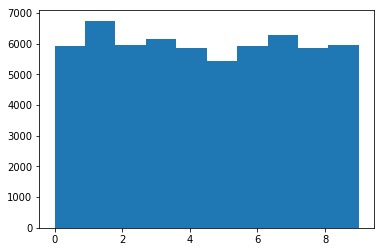

In [5]:
plt.hist(y_train)

The class distribution in y_train is homogeneous which is perfect for an efficient training and for enabling the model to be able to recognize every digit. 

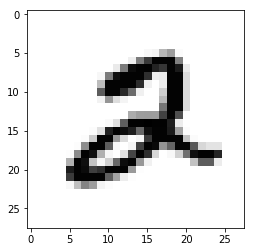

In [6]:
#Show first digit 
pixels = X_train[5].reshape((28,28))
plt.imshow(pixels, cmap = 'Greys')

## Reshaping and Normalizing the images

In [7]:
# Reshaping the array to 4-dims so that it can work with the Keras API
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print('Number of images in X_train', X_train.shape[0])
print('Number of images in X_test', X_test.shape[0])

X_train shape: (60000, 28, 28, 1)
Number of images in X_train 60000
Number of images in X_test 10000


## Linear Support Vector Classification

Here, we need arrays of one dimension for each data point:

In [76]:
X_train= X_train.reshape(60000,784)
X_test = X_test.reshape(10000, 784)

In [77]:
#Test different values for C:
param_grid = {"C" : [0.01, 0.1, 1]}
lc = LinearSVC()
grid = GridSearchCV(estimator=lc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=1)

lc = grid.fit(X_train, y_train)

print(f"best params : {lc.best_params_}")
lc= lc.best_estimator_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.3min finished


best params : {'C': 0.1}


In [78]:
#Fitting the Linear SVM with the best parameter
lc = LinearSVC(C = 0.1, verbose=1)

start_time = time.time()
lc = lc.fit(X_train, y_train)
lc_train_time = time.time() - start_time


[LibLinear]

In [79]:
start_time = time.time()
predictions = lc.predict(X_test)
lc_test_time = time.time() - start_time

lc_accuracy = lc.score(X_test, y_test)
print(f"accuracy: {lc_accuracy}")
print(f"training time: {lc_train_time} seconds")
print(f"testing time: {lc_test_time} seconds")
print(f"confusion matrix: \n {confusion_matrix(predictions,y_test)}")


accuracy: 0.9182
training time: 34.593847036361694 seconds
testing time: 0.11180806159973145 seconds
confusion matrix: 
 [[ 959    0   10    4    1    9   10    2   11    7]
 [   0 1112   10    0    4    2    3    9   14    8]
 [   2    3  916   18    4    1    7   23    7    2]
 [   2    2   18  922    2   40    2    5   20   14]
 [   1    0   10    2  914   12    6    9   15   33]
 [   4    1    5   21    0  767   21    1   31   12]
 [   7    5   12    4   10   17  907    1    9    0]
 [   3    1   11   11    2    7    1  946   13   24]
 [   1   11   36   19    6   29    1    4  841   11]
 [   1    0    4    9   39    8    0   28   13  898]]


## Neural Network

In [66]:
X_train = X_train.reshape([60000, 28, 28])
X_test = X_test.reshape([10000, 28, 28])

In [67]:
#Build a network with a sequence of two layers. The first dense has 128 nodes and the second dense 
#is a 10-node softwmax layer : it returns 10 probability scores that sum to 1. They correspond to 
#the probability that the image belongs to the class. 

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28))
])

d1 = keras.layers.Dense(128, activation=tf.nn.relu)
d_class = keras.layers.Dense(10, activation=tf.nn.softmax)

model.add(d1)
model.add(d_class)


In [68]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
start_time = time.time()
model.fit(X_train, y_train, epochs = 5)
nn_train_time = time.time() - start_time

Epoch 1/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.2581 - acc: 0.9262
Epoch 2/5
60000/60000 [==============================] - 5s 90us/step - loss: 0.1145 - acc: 0.9663
Epoch 3/5
60000/60000 [==============================] - 5s 91us/step - loss: 0.0792 - acc: 0.9760
Epoch 4/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0572 - acc: 0.9823
Epoch 5/5
60000/60000 [==============================] - 6s 96us/step - loss: 0.0456 - acc: 0.9859


In [12]:
(nn_test_loss, nn_test_acc) = model.evaluate(X_test, y_test)
print("Test accuracy :", nn_test_acc)

start_time = time.time()
predictions= model.predict(X_test).argmax(axis=1)
nn_test_time = time.time() - start_time

print(f"training time: {nn_train_time} seconds")
print(f"testing time: {nn_test_time} seconds")

print( "confusion matrix : \n", confusion_matrix(predictions,y_test) )

10000/10000 [==============================] - 0s 33us/step
Test accuracy : 0.9776
training time: 25.018759965896606 seconds
testing time: 0.18279290199279785 seconds
confusion matrix : 
 [[ 972    0    5    0    0    3    5    1    3    3]
 [   1 1127    0    0    0    0    3    3    1    3]
 [   1    2 1013    7    6    0    3    9    3    0]
 [   0    0    1  983    1   11    1    3    6    4]
 [   0    0    1    1  961    1    6    0    4   10]
 [   1    1    0    3    0  864    5    0    4    3]
 [   1    1    1    0    2    1  930    0    1    0]
 [   1    1    7    3    3    2    0 1006    4    5]
 [   2    3    4    6    1    7    5    3  947    8]
 [   1    0    0    7    8    3    0    3    1  973]]


#### Optimize the algorithm : 

In [ ]:
#Change network depth 
def create_dense(layer_sizes):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28,28))
    ])
    
    d1 = keras.layers.Dense(layer_sizes[0], activation=tf.nn.relu)
    model.add(d1)

    for s in layer_sizes[1:]:
        d = keras.layers.Dense(units = s, activation = tf.nn.relu)
        model.add(d)

    d_class = keras.layers.Dense(units=10, activation=tf.nn.softmax)
    model.add(d_class)
    return model

In [ ]:
#Evaluate the model 
def evaluate(model, epochs=5):
    model.summary()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=.1, verbose=False)
    loss, accuracy  = model.evaluate(X_test, y_test, verbose=False)
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [ ]:
for nodes in [128, 256, 1024, 2048]:
    model = create_dense([nodes])
    evaluate(model, epochs = 3)

Adding too many layers overfits the model. The best accuracy is obtained with only one layer in the neural network. With more layers, the neural network fits the training data too precisely, and no longer generalized to data from outside the training set (here, to X_test). Especially with 5 hidden layers we can see that the training accuracy is way larger than the test accuracy, which is an indicator for overfitting. 

More nodes in the hidden layers produce a better performance on the test data. The model reaches the best accuracy with one hidden layer of 2048 nodes. 

In [ ]:
#Final model 

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28))
])

d1 = keras.layers.Dense(2048, activation=tf.nn.relu)
d_class = keras.layers.Dense(10, activation=tf.nn.softmax)

model.add(d1)
model.add(d_class)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train)

(nn_test_loss, nn_test_acc) = model.evaluate(X_test, y_test)
predictions= model.predict(X_test).argmax(axis=1)

print("Test accuracy :", nn_test_acc)
print( "confusion matrix : \n", confusion_matrix(predictions,y_test) )

## CNN

In [46]:
np.random.seed(42)

model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(5, 5),
                 padding='Same',
                 activation='relu',
                 input_shape=(28, 28, 1)))

model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='Same',
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 padding='Same',
                 activation='relu'))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

In [16]:
X_train = X_train.reshape([60000, 28, 28,1])
X_test = X_test.reshape([10000, 28, 28,1])

In [48]:
epochs = 2
batch_size = 86

start_time = time.time()
model.fit(X_train, y_train, 
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=1)
cnn_train_time = time.time() - start_time

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 315s 5ms/step - loss: 0.1799 - acc: 0.9431 - val_loss: 0.0366 - val_acc: 0.9883
Epoch 2/2
60000/60000 [==============================] - 310s 5ms/step - loss: 0.0561 - acc: 0.9833 - val_loss: 0.0226 - val_acc: 0.9926


In [49]:
(cnn_test_loss, cnn_test_acc) = model.evaluate(X_test, y_test)

start_time = time.time()
predictions= model.predict(X_test).argmax(axis=1)
cnn_test_time = time.time() - start_time

print("Test accuracy :", cnn_test_acc)
print(f"training time: {cnn_train_time} seconds")
print(f"testing time: {cnn_test_time} seconds")
print( "confusion matrix : \n", confusion_matrix(predictions,y_test) )

10000/10000 [==============================] - 15s 1ms/step
Test accuracy : 0.9926
training time: 625.6218590736389 seconds
testing time: 15.001692056655884 seconds
confusion matrix : 
 [[ 976    0    0    0    0    0    2    0    0    1]
 [   0 1130    0    0    0    0    3    2    0    0]
 [   0    0 1030    0    1    0    0    4    2    0]
 [   0    2    0 1006    0    3    0    1    2    0]
 [   0    0    0    0  971    0    1    0    0    2]
 [   0    0    0    3    0  886    2    1    1    4]
 [   2    1    0    0    2    1  949    0    0    0]
 [   1    1    1    0    0    1    0 1012    0    0]
 [   1    1    1    0    1    0    1    1  967    3]
 [   0    0    0    1    7    1    0    7    2  999]]


## K Nearest Neighbors

In [53]:
X_train = X_train.reshape(60000,784)
X_test = X_test.reshape(10000,784)

Here, we train the KNN on a smaller number of data because otherwise it takes too long. The code to train the KNN with all the data is still provided below. 

In [54]:
#Load the data from the mnist dataset in sklearn and split it into train and test samples
mnist = datasets.load_digits()
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(mnist.data),
mnist.target, test_size=0.25, random_state=42)

# now, let's take 10% of the training data and use that for validation
(images_train1, valData, labels_train1, valLabels) = train_test_split(trainData, trainLabels,
test_size=0.1, random_state=84)

# show the sizes of each data split
print(f"training data points: {len(images_train1)}")
print(f"validation data points: {len(valLabels)}")
print(f"testing data points: {len(testData)}")

training data points: 1212
validation data points: 135
testing data points: 450


In [55]:
# now, let's take 10% of the training data and use that for validation

#(images_train1, valData, labels_train1, valLabels) = train_test_split(X_train, y_train,
#test_size=0.1, random_state=84)


# show the sizes of each data split

#print(f"training data points: {len(images_train1)}")
#print(f"validation data points: {len(valLabels)}")
#print(f"testing data points: {len(y_test)}")

In [56]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k

kVals = range(1,10,2)
accuracies = []

# loop over various values of k for the k-Nearest Neighbor classifier

for k in range(1,10,2):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(images_train1, labels_train1)
    score = model.score(valData, valLabels)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

        

i = np.argmax(accuracies)
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i],
accuracies[i] * 100))

k=1, accuracy=99.26%
k=3, accuracy=99.26%
k=5, accuracy=99.26%
k=7, accuracy=99.26%
k=9, accuracy=99.26%
k=1 achieved highest accuracy of 99.26% on validation data


In [57]:
model = KNeighborsClassifier(n_neighbors=k+1)

model.fit(images_train1, labels_train1)

# evaluate the model and update the accuracies list
score = model.score(valData, valLabels)
print("k=%d, accuracy=%.2f%%" % (k, score * 100))
accuracies.append(score)

k=9, accuracy=99.26%


In [58]:
# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits
predictions = model.predict(testData)

print("EVALUATION ON TESTING DATA")
print(classification_report(testLabels, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.95      1.00      0.97        37
           2       1.00      1.00      1.00        38
           3       0.98      1.00      0.99        46
           4       0.98      1.00      0.99        55
           5       0.98      0.97      0.97        59
           6       0.98      1.00      0.99        45
           7       1.00      1.00      1.00        41
           8       1.00      0.95      0.97        38
           9       0.98      0.94      0.96        48

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.99      0.98       450
weighted avg       0.98      0.98      0.98       450



In [59]:
# re-train our classifier using the best k value and predict the labels of the
# test data
start_time = time.time()
model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(images_train1, labels_train1)
knn_train_time = time.time() - start_time

start_time = time.time()
predictions = model.predict(valData)
knn_test_time = time.time() - start_time


knn_score = model.score(valData, valLabels)
print("k=%d, accuracy=%.2f%%" % (1, knn_score * 100))
print(f"training time: {knn_train_time} seconds")
print(f"testing time: {knn_test_time} seconds")


k=1, accuracy=99.26%
training time: 0.0036580562591552734 seconds
testing time: 0.02188706398010254 seconds


## Perfomance assessment of the different models

In [80]:
dash = '-' * 60
print(dash)
print("{:<11s}{:<15s}{:<15s}{:<15s}".format("Term", "Accuracy", "Training Time", "Testing Time"))
print(dash)
print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}".format("LC",lc_accuracy, lc_train_time, lc_test_time))
print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}".format("NN", nn_test_acc, nn_train_time, nn_test_time)) 
print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}".format("CNN", cnn_test_acc, cnn_train_time, cnn_test_time))  
print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}".format("KNN", knn_score, knn_train_time, knn_test_time))
print(dash)   

------------------------------------------------------------
Term       Accuracy       Training Time  Testing Time   
------------------------------------------------------------
LC               0.918      34.594       0.112
NN               0.978      28.930       0.183
CNN              0.993     625.622      15.002
KNN              0.993       0.004       0.022
------------------------------------------------------------


The best accuray is obtained with the KNN, but on a very small number of data (only 1212 training data, 135 validation data and 450 testing data). On a larger amount of data, this algorithm takes much more longer to run and requires more power. Thus, the best performing algorithm here is probably the CNN : it has the best accuracy with reasonable training and testing times. 

## GAN

In [62]:
os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ['KERAS_BACKEND']='tensorflow'

%matplotlib inline

In [63]:
X_train, y_train = loadlocal_mnist(
        images_path='data/train-images-idx3-ubyte', 
        labels_path='data/train-labels-idx1-ubyte')

X_test, y_test = loadlocal_mnist(images_path = 'data/t10k-images-idx3-ubyte', 
                                labels_path = 'data/t10k-labels-idx1-ubyte')

In [64]:
random_dim = 100
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

In [65]:
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

Implement the Generator

In [66]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim,
                       kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator


And the discriminator

In [67]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784,
                       kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator




Train model against each other

In [68]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=(random_dim,))
    x=generator(gan_input)
    gan_output = discriminator(x)
    gan=Model(inputs=gan_input, outputs = gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [69]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28,28)
    
    plt.figure(figsize=figsize)
    
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig('gan_res/gan_generated_image_epoch_'+str(epoch)+'.png')
    #you have to create the repository "gan_res" in "MNIST-Handwritten-digits-recognition-"

In [72]:
def train(epochs=1, batch_size=128):
    
    batch_count = int(X_train.shape[0]/batch_size)
    
    adam = get_optimizer()
    generator = get_generator(adam)
    discrimnator = get_discriminator(adam)
    gan = get_gan_network(discrimnator, random_dim, generator, adam)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' %e, '-'*15)
        for _ in tqdm_notebook(range(batch_count)):
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            generated_images = generator.predict(noise)
            X=np.concatenate([image_batch, generated_images])
            
            y_dis = np.zeros(2*batch_size)
            
            y_dis[:batch_size] = 0.9
            
            discrimnator.trainable = True
            discrimnator.train_on_batch(X, y_dis)
            
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            
            discrimnator.trainable = False
            gan.train_on_batch(noise, y_gen)
        plot_generated_images(e, generator)
        



--------------- Epoch 1 ---------------


--------------- Epoch 2 ---------------


--------------- Epoch 3 ---------------


--------------- Epoch 4 ---------------


--------------- Epoch 5 ---------------


--------------- Epoch 6 ---------------


--------------- Epoch 7 ---------------


--------------- Epoch 8 ---------------


--------------- Epoch 9 ---------------


KeyboardInterrupt: 

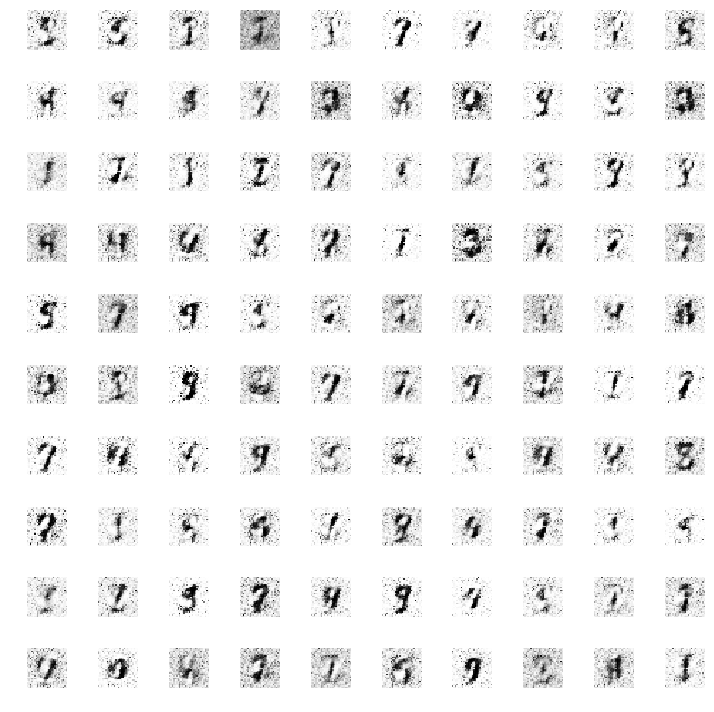

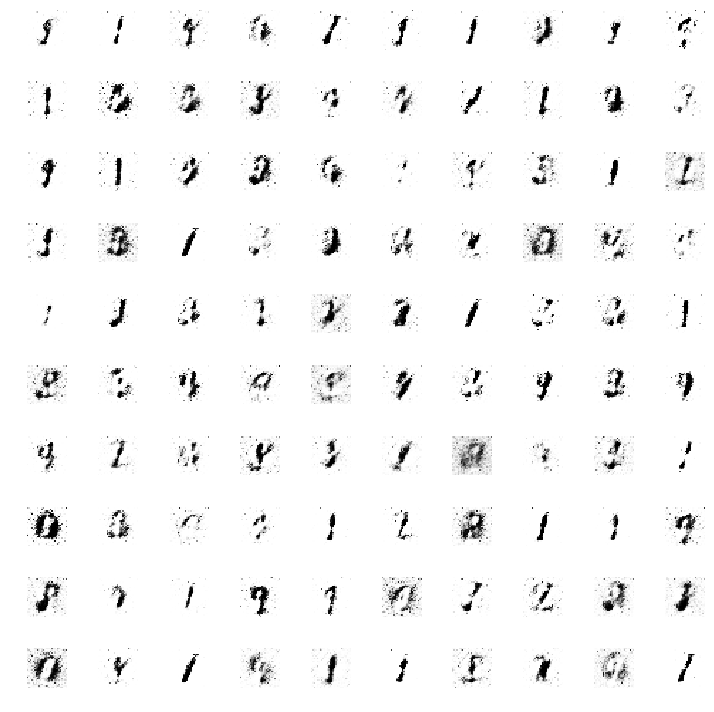

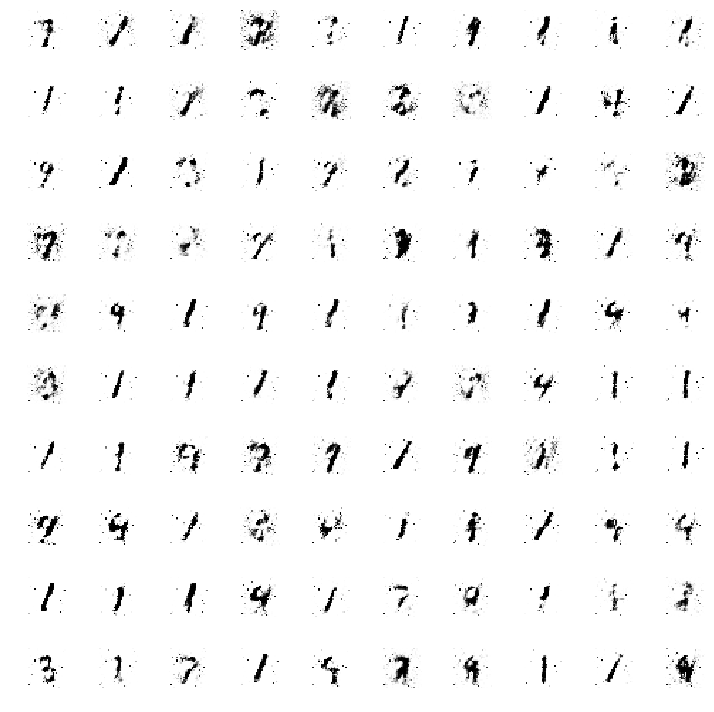

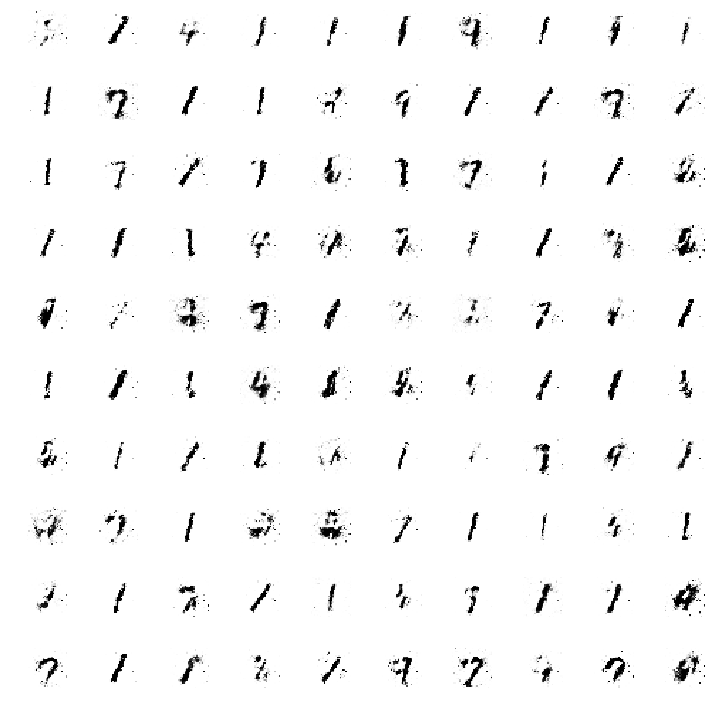

In [ ]:
train(20, 128)

## Input our own images

Yann Lecun : "All images are size normalized to fit in a 20x20 pixel box and they are centered in a 28x28 image using the center of mass. These are important information for our preprocessing".
We need to do the exact preprocessing described by Yann Lecun to be able to recognize our own handwritten digits. 

Steps for our image preprocessing: 

- Digits written in black on a white blackground --> invert the colors because to obtain white digits on a black background.
- The quality of the image is not perfect so we have a lot of gray areas in the picture. We can fix this by adding a treshold for assigning the gray color to white or black, and have only black and white colors left in the image. 
- We want the image to fit into a 20x20 pixel box so we remove the black rows at the side of the image and we resize it into 20x20. 
- The images need to be centered in a 28x28 image using the center of mass: we add missing black rows and columns to obtain an 28x28 image, we find the center of mass and we shift the image in that direction. 
- Lastly, we divide the obtained array by 255 to obtain values between 0 and 1. 

In [13]:
#Get the center of mass
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

In [14]:
#Shift the image
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [15]:
images = np.zeros((9,784))

for i in range(9):
    gray = cv2.imread("Our_own_images/img" + str(i) + ".jpeg", 0)  #Open image
    gray = cv2.resize(255-gray, (28, 28)) #Resize image and invert it with a black background
    (thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) #Add a treshold to have only black or white in the image, no gray 
    
    #Remove completely black rows and columns at the sides of the image
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    
    #Resize the image so that it fits into a 20x20 box
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        gray = cv2.resize(gray, (cols,rows))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        gray = cv2.resize(gray, (cols, rows))
        
        
    #Add missing black rows and columns to get a 28x28 image
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    
    #Find the center of mass and shift the image in the given directions
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    gray = shifted

    #Divide by 255 to obtain a range from 0 to 1, just like for the images in the MNIST dataset   
    flatten = gray.flatten() / 255.0
    
    images[i] = flatten


In [72]:
#Reshape images for the Neural Network
images = images.reshape(9,28,28)

In [73]:
#See if the Neural Network recognizes our handwriting !
images_labels=np.array([1.,4.,6.,9.,2.,1.,3.,5.,4.]).reshape(9,)
predictions = model.predict(images)
for i in range(9):
    predictions[i] = predictions[i].argmax()

print(f'accuracy:{model.evaluate(images,images_labels)[1]}')
print("Consusion matrix:\n")
print(confusion_matrix(predictions[:,1], images_labels))

9/9 [==============================] - 0s 11ms/step
accuracy:0.5555555820465088
Consusion matrix:

[[0 0 0 0 0 0 0]
 [2 1 1 0 0 0 1]
 [0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]
